In [1]:
import sys
import torch
import os 
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import wandb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import gaussian_filter
from PIL import Image
sys.path.append('..')  
import scipy
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import torch
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from torchvision import models, transforms
from types import SimpleNamespace
from model.model import MMC  
from src.config import Config
import pickle
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

/raid/nlp/rajak/Multimodal/UniS-MMC/multimodal/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = SimpleNamespace(
    name='MMC',
    dataset='Food101',  # Adjust as per your dataset or requirement
    text_type='abstract',
    mmc='UniSMMC',
    mmc_tao=0.07,
    batch_size=32,
    lr_mm=0.001,
    min_epoch=1,
    valid_step=50,
    max_length=512,
    text_encoder='bert_base',
    image_encoder='vit_base',
    text_out=768,
    img_out=768,
    lr_mm_cls=0.001,
    mm_dropout=0.0,
    lr_text_tfm=2e-5,
    lr_img_tfm=5e-5,
    lr_img_cls=0.0001,
    lr_text_cls=5e-5,
    text_dropout=0.0,
    img_dropout=0.1,
    nplot='',
    data_dir='../datasets/',  # Ensure this path is correct in your notebook environment
    test_only=False,
    pretrained_dir='../pretrained_models',  # Adjust as necessary
    model_save_dir='Path/To/results/models',
    res_save_dir='Path/To/results/results',
    fig_save_dir='Path/To/results/imgs',
    logs_dir='Path/To/results/logs',
    local_rank=-1,
    seeds=None,
    model_path='./Path/To/results/models',
    save_model=True,
    cross_attention=False,
    text_mixup=False,
    image_mixup=False,
    image_embedding_mixup=False,
    alpha=0.2,
    multi_mixup=True,
    mixup_pct=0.33,
    lambda_mixup=0.1,
    mixup_beta=0.15,
    mixup_s_thresh=0.5,
    lr_scheduler='ReduceLROnPlateau',
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

config = Config(args)
args = config.get_config()

np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

if args.local_rank == -1:
    device = torch.device("cuda")
else:
    torch.cuda.set_device(args.local_rank)
    device = torch.device("cuda", args.local_rank)
    torch.distributed.init_process_group(backend="nccl")

args.device = device
print(args.data_dir)
args.data_dir = os.path.join(args.data_dir, args.dataset)

#args.best_model_save_path = os.path.join(args.model_save_dir, f'{args.dataset}-best-{time.strftime("%Y%m%d-%H%M%S")}.pth')

../datasets/


In [3]:
model = MMC(args)
multimixco_softclip_model_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/Path/To/results/models/Food101-best-m3col.pth'
model.load_state_dict(torch.load(multimixco_softclip_model_path))
model_both = model.to(device=args.device)

In [4]:
def get_sentence_embedding(text, model, args):
    # Assuming the model's text_encoder has already been initialized
    tokenizer = model.text_encoder.get_tokenizer()
    encoded_input = tokenizer(text, return_tensors="pt")
    input_ids = encoded_input['input_ids'].to(device=args.device)
    attention_mask = encoded_input['attention_mask'].to(device=args.device)

    with torch.no_grad():
        if 'roberta' in model.text_encoder.text_encoder:
            embeddings = model.text_encoder.forward((input_ids, None, attention_mask))
        else:
            token_type_ids = encoded_input.get('token_type_ids').to(device=args.device)
            embeddings = model.text_encoder.forward((input_ids, token_type_ids, attention_mask))

    embeddings = embeddings.squeeze(dim = 0)
    final_embedding = embeddings[0, :]
    final_embedding = final_embedding / final_embedding.norm()

    return final_embedding

In [5]:
def get_image_embedding(image_path, model, args):
    image = Image.open(image_path).convert('RGB')
    feature_extractor = model.image_encoder.get_tokenizer()  # Ensure this method is properly returning the feature extractor
    inputs = feature_extractor(images=image, return_tensors="pt")
    pixel_values = inputs['pixel_values']

    model.eval()
    pixel_values = pixel_values.to(args.device)  
    # Extract embeddings
    with torch.no_grad():
        image_embeddings = model.image_encoder(pixel_values)
    
    image_embeddings = image_embeddings.squeeze()
    # Taking final embedding as cls embedding
    final_embedding = image_embeddings[0,:]
    final_embedding = final_embedding / final_embedding.norm()
    
    return final_embedding

In [6]:
def get_combined_embedding(image, text, model, args):
    
    feature_extractor = model.image_encoder.get_tokenizer()  # Ensure this method is properly returning the feature extractor
    inputs = feature_extractor(images=image, return_tensors="pt")
    pixel_values = inputs['pixel_values']

    model.eval()
    pixel_values = pixel_values.to(args.device)  
    # Extract embeddings
    with torch.no_grad():
        image_embeddings = model.image_encoder(pixel_values)
    
    image_embeddings = image_embeddings.squeeze()
    # Taking final embedding as cls embedding
    final_embedding_image = image_embeddings[0,:]
    final_embedding_image = final_embedding_image / final_embedding_image.norm()
    
    tokenizer = model.text_encoder.get_tokenizer()
    encoded_input = tokenizer(text, return_tensors="pt")
    input_ids = encoded_input['input_ids'].to(device=args.device)
    attention_mask = encoded_input['attention_mask'].to(device=args.device)

    with torch.no_grad():
        if 'roberta' in model.text_encoder.text_encoder:
            text_embeddings = model.text_encoder.forward((input_ids, None, attention_mask))
        else:
            token_type_ids = encoded_input.get('token_type_ids').to(device=args.device)
            text_embeddings = model.text_encoder.forward((input_ids, token_type_ids, attention_mask))

    text_embeddings = text_embeddings.squeeze(dim = 0)
    final_embedding_text = text_embeddings[0, :]
    final_embedding_text = final_embedding_text / final_embedding_text.norm()

    final_fused_combined = torch.cat([final_embedding_text, final_embedding_image], dim=-1)
        #final_fused_combined = final_fused_combined / final_fused_combined.norm(dim=-1, keepdim=True)
    return final_embedding_image, final_embedding_text, final_fused_combined

In [7]:
def get_image_paths(folder_path, extension="jpg"):
    return [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith(extension)]

def get_text_paths(folder_path, extension="txt"):
    return [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith(extension)]

In [8]:
def save_embeddings(model, model_name, args, subfolders, class_to_label, classes_to_be_considered):
    folder_path_images_test = '/raid/nlp/rajak/Multimodal/UniS-MMC/datasets/Food101/images/test'
    csv_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/datasets/Food101/test.csv'
    save_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks'
    label_to_class = {i:class_name for class_name,i in class_to_label.items() }

    test_image_embeddings = {}
    test_text_emebddings = {}
    test_combined_embeddings = {}
    order_of_ids = {}

    for class_name in subfolders:
        test_image_embeddings[class_name] = [] 
        test_text_emebddings[class_name] = []
        test_combined_embeddings[class_name] = []
        order_of_ids[class_name] = []
    
            
    data = pd.read_csv(csv_path)
    for index, row in tqdm(data.iterrows(), total = data.shape[0]):
        if row['annotation'] in classes_to_be_considered:
            image_path = folder_path_images_test + '/' + row['annotation'] + '/' + row['id'] 
            text = row['text']
            image = Image.open(image_path).convert('RGB')

            final_embedding_image, final_embedding_text, final_fused_combined = get_combined_embedding(image, text, model, args)
            order_of_ids[class_name].append(row['id'])
            class_name = row['annotation']
            test_image_embeddings[class_name].append(final_embedding_image.cpu().numpy())
            test_text_emebddings[class_name].append(final_embedding_text.cpu().numpy())
            test_combined_embeddings[class_name].append(final_fused_combined.cpu().numpy())
    
    
    with open(os.path.join(save_path, 'Food101_test_image_embeddings_' + model_name + '.pkl'), 'wb') as f:
        pickle.dump(test_image_embeddings, f)
    with open(os.path.join(save_path, 'Food101_test_text_emebddings_' + model_name + '.pkl'), 'wb') as f:
        pickle.dump(test_text_emebddings, f)
    with open(os.path.join(save_path, 'Food101_test_combined_embeddings_' + model_name + '.pkl'), 'wb') as f:
        pickle.dump(test_combined_embeddings, f)
    with open(os.path.join(save_path, 'Food101_order_of_ids_' + model_name + '.pkl'), 'wb') as f:
        pickle.dump(order_of_ids, f)

In [9]:
folder_path_images_test = '/raid/nlp/rajak/Multimodal/UniS-MMC/datasets/Food101/images/test'
subfolders = [f.name for f in os.scandir(folder_path_images_test) if f.is_dir()]
class_to_label = {class_name: i for i, class_name in enumerate(subfolders)}
label_to_class = {i:class_name for class_name,i in class_to_label.items() }

count = {}
for class_name in subfolders:
    directory_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/datasets/Food101/images/test' + '/' + class_name
    files = os.listdir(directory_path)
    count[class_name] = len(files)

count_sorted = dict(sorted(count.items(), key=lambda item: item[1], reverse=True))
print(count_sorted)
classes_to_be_considered = []
i = 0
for class_name in count_sorted.keys():
    classes_to_be_considered.append(class_name)
    i += 1
    if i == 10:
        break 
print(classes_to_be_considered)

{'french_toast': 238, 'macaroni_and_cheese': 238, 'sushi': 237, 'ravioli': 236, 'risotto': 236, 'pizza': 235, 'waffles': 235, 'gnocchi': 234, 'mussels': 234, 'hot_dog': 234, 'pancakes': 234, 'apple_pie': 234, 'hummus': 234, 'frozen_yogurt': 233, 'lasagna': 233, 'hamburger': 233, 'tacos': 233, 'cheesecake': 233, 'tiramisu': 232, 'gyoza': 232, 'chocolate_cake': 232, 'donuts': 232, 'ice_cream': 232, 'ramen': 232, 'carrot_cake': 231, 'macarons': 231, 'omelette': 231, 'bruschetta': 231, 'edamame': 231, 'cannoli': 230, 'spring_rolls': 230, 'churros': 230, 'pad_thai': 230, 'steak': 229, 'deviled_eggs': 229, 'fried_rice': 229, 'grilled_cheese_sandwich': 229, 'falafel': 228, 'paella': 228, 'scallops': 228, 'guacamole': 228, 'dumplings': 228, 'cup_cakes': 228, 'shrimp_and_grits': 228, 'pork_chop': 227, 'red_velvet_cake': 227, 'caesar_salad': 227, 'ceviche': 227, 'miso_soup': 227, 'sashimi': 226, 'bread_pudding': 226, 'baklava': 226, 'panna_cotta': 225, 'grilled_salmon': 225, 'creme_brulee': 225,

In [28]:
save_embeddings(model_both, "both", args, subfolders, class_to_label, classes_to_be_considered)

  0%|          | 0/21683 [00:00<?, ?it/s]

100%|██████████| 21683/21683 [00:56<00:00, 383.34it/s] 


In [19]:
def get_figures_2(base_path, model_name, class_to_label, type):
    file_path = base_path + model_name + '.pkl'
    with open(os.path.join(file_path), 'rb') as f:
        embeddings_saved = pickle.load(f)
    
    embeddings = []
    labels = []
    for class_name in embeddings_saved.keys():
        label = class_to_label[class_name]
        embeddings = embeddings + embeddings_saved[class_name]
        label_list = [label]*len(embeddings_saved[class_name])
        labels = labels + label_list 

    labels = np.array(labels)
    print("MODEL NAME: ") 
    print(model_name)

    if len(embeddings) != len(labels):
        raise ValueError("The number of embeddings must match the number of labels")

    # Setting UMAP parameters
    n_neighbors = 15
    n_components = 2
    min_dist_value = 0.5  # Example: A smaller distance
    spread_value = 3    # Default value

    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, 
                        metric='euclidean', min_dist=min_dist_value, spread=spread_value)
    embedding = reducer.fit_transform(embeddings)  # Reduce dimensionality

    # Create a DataFrame for easier plotting
    umap_df = pd.DataFrame(embedding, columns=['UMAP dimension 1', 'UMAP dimension 2'])
    umap_df['label'] = labels

    # Plotting
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='UMAP dimension 1', y='UMAP dimension 2', hue='label', data=umap_df, palette=sns.color_palette("bright", len(pd.unique(umap_df['label']))), legend= False)
    plt.title('Food101', fontsize=25)  # Increase title font size
    plt.xlabel('UMAP dimension 1', fontsize=20)  # Increase x-axis label font size
    plt.ylabel('UMAP dimension 2', fontsize=20)  # Increase y-axis label font size
    plt.xticks(fontsize=17)  # Increase x-ticks font size
    plt.yticks(fontsize=17)  # Increase y-ticks font size

    plt.show()
    # visualize_embeddings(type, embeddings, labels, method="umap")
    # silh_score = silhouette_score(embeddings, labels)
    # db_score = davies_bouldin_score(embeddings, labels)
    # ch_score = calinski_harabasz_score(embeddings, labels)
    # print(f"Davies-Bouldin Score: {db_score}")
    # print(f"Calinski-Harabasz Score: {ch_score}")
    # print(f"Silhouette Score: {silh_score}")

MODEL NAME: 
both


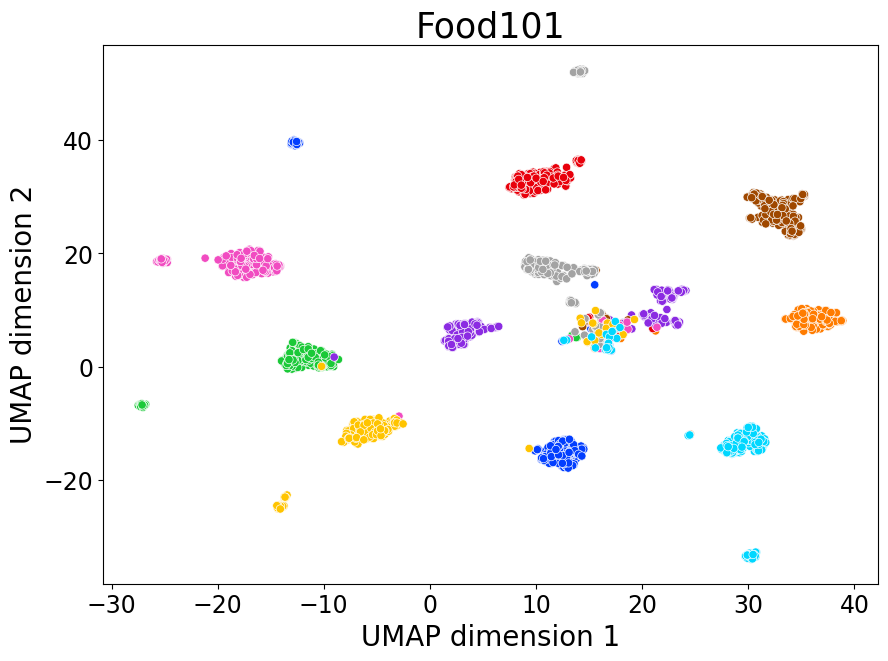

In [20]:
base_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/' + 'Food101_test_text_emebddings_'
model_name = "both"
get_figures_2(base_path, model_name, class_to_label, 'text')

MODEL NAME: 
both


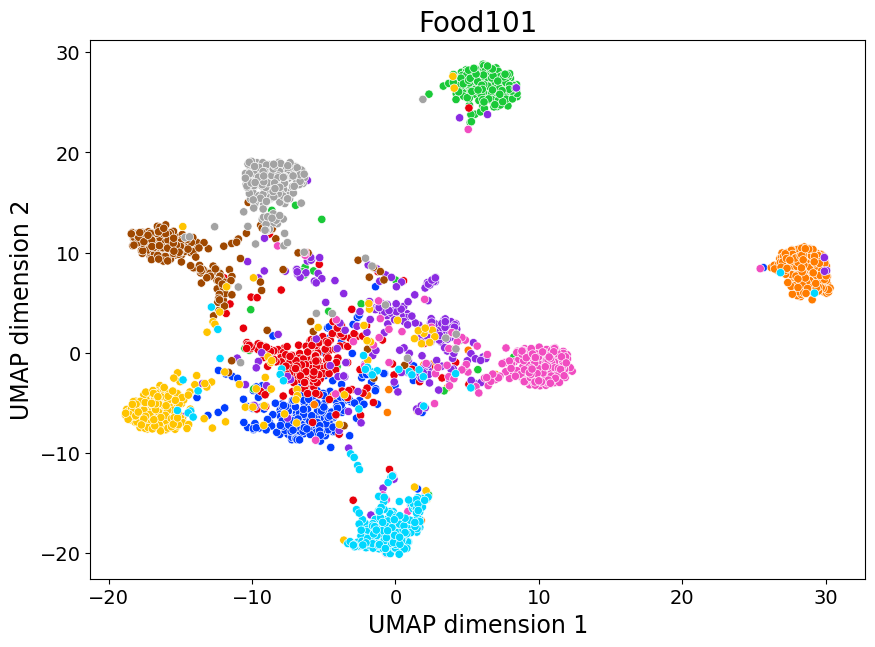

In [17]:
base_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/' + 'Food101_test_image_embeddings_'
model_name = "both"
get_figures_2(base_path, model_name, class_to_label, 'image')

MODEL NAME: 
both


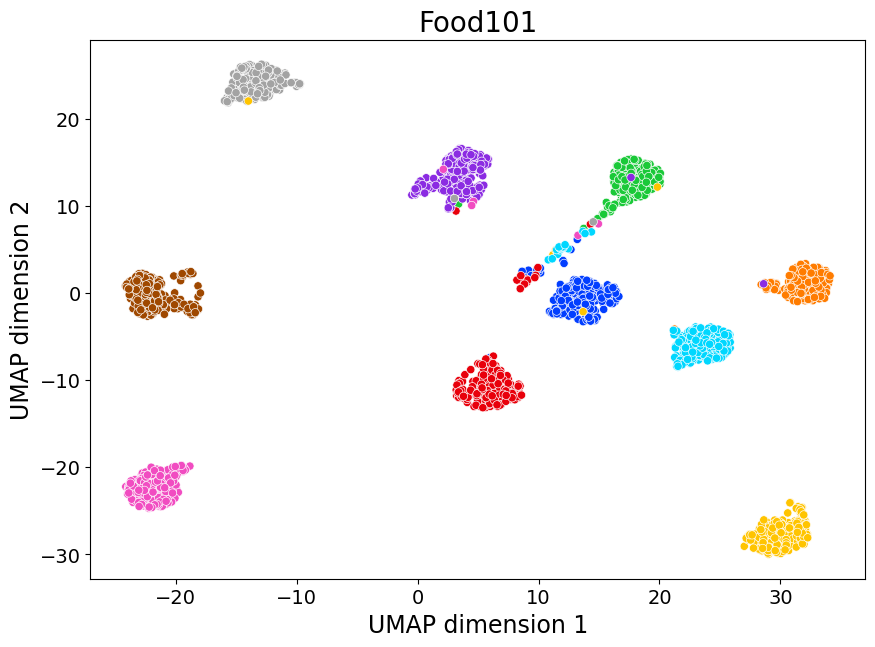

In [18]:
base_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/' + 'Food101_test_combined_embeddings_'
model_name = "both"
get_figures_2(base_path, model_name, class_to_label, 'combined')